In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)
cwd=os.getcwd()

import pymc3 as pm
import theano
import theano.tensor as tt
import integration as inn
import background as bg

In [2]:
path_data = cwd + '/data/SN.txt'
data_file = Path(path_data)
if data_file.is_file():
    data = np.genfromtxt(path_data)
    z_obs = data[:,0]
    mu_obs = data[:,1]
    dmu_obs = data[:,2]
    print("SN data are loaded")
    
else:
    print("SN files do not exist")
    sys.exit(0) 

SN data are loaded


In [3]:
num = 2
@theano.compile.ops.as_op(itypes=[tt.dscalar for i in range(num)],otypes=[tt.dvector])
def mu_the_pymc(H0,om):
        return bg.mu_the(z_obs,H0,om)


def log_likelihood(H0,om):
    mu = mu_the_pymc(H0,om)
    x = (mu - mu_obs)/dmu_obs 
    return -0.5*pm.math.dot(x,x)


with pm.Model() as basic_model:
    H0 = pm.Uniform('H0', 60., 80.)
    om = pm.Uniform('om', 0.1, .4)

    like = pm.Potential('like', log_likelihood(H0,om))
    #y = pm.Normal('y', mu=tt.as_tensor_variable(mu_func(a,b)), sd=0.1, observed=y_obs)
    #y = pm.Normal('y', mu=mu_the_pymc(H0,om), sd=dmu_obs, observed=mu_obs)

    step = pm.Metropolis()
    #step = None
    #step=pm.SMC()
    #step=pm.HamiltonianMC()
    trace = pm.sample(2000,tune=1000, cores=2,chains=2,step=step)


TypeError: Hub_inv() missing 1 required positional argument: 'om'

In [ ]:
print(pm.summary(trace))
pm.traceplot(trace)

In [3]:
def lom_dis_gr(z,H0,om):
    start = theano.shared(0.)
    stop = [theano.shared(x) for x in z]

    t = tt.dscalar('t')
    t.tag.test_value = np.ones(())

    a_ = tt.dscalar('a_')
    a_.tag.test_value = np.ones(())*70

    b_ = tt.dscalar('b_')
    b_.tag.test_value = np.ones(())*0.1

    func = bg.Hub_inv(t,a_,b_)

    integrate = inn.Integrate(func,t,a_,b_)
    dis = [integrate(start,stop[i],H0,om) for i in range(len(z))]

    return 3e5*(1+z)*tt.as_tensor_variable(dis)

def mu_gr(H0,om):
    return 5*tt.log10(lom_dis_gr(z_obs,H0,om)) + 25.


def log_like_gr(H0,om):
    mu = mu_gr(H0,om)
    x = (mu - mu_obs)/dmu_obs 
    return -0.5*pm.math.dot(x,x)

In [4]:
with pm.Model() as basic_model:
    H0 = pm.Uniform('H0', 60., 80.)
    om = pm.Uniform('om', 0.1, .4)

    #like = pm.Potential('like', log_like_gr(H0,om))
    #y = pm.Normal('y', mu=tt.as_tensor_variable(mu_func(a,b)), sd=0.1, observed=y_obs)
    y = pm.Normal('y', mu=mu_gr(H0,om), sd=dmu_obs, observed=mu_obs)

    #step = pm.Metropolis()
    #step = None
    #step=pm.SMC()
    step=pm.HamiltonianMC()
    trace = pm.sample(1000,tune=500, cores=2,chains=2,step=step)

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [om, H0]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 572 seconds.


/home/ahmad/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
H0  71.875  0.226  71.477   72.314      0.009    0.007     575.0   575.0   
om   0.284  0.013   0.260    0.309      0.001    0.000     604.0   604.0   

    ess_bulk  ess_tail  r_hat  
H0     577.0     684.0    1.0  
om     608.0     694.0    1.0  


/home/ahmad/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5d5a24b10>,
      dtype=object)

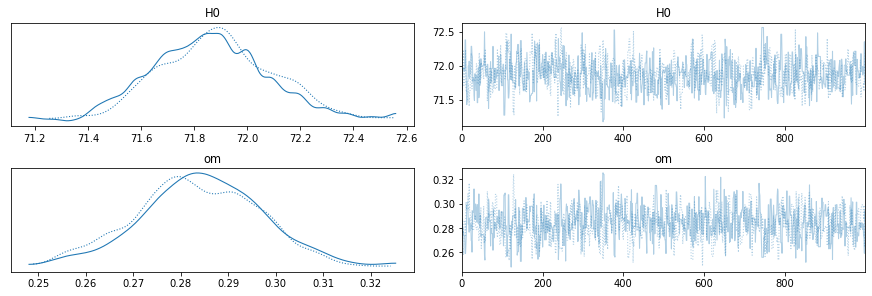

In [5]:
print(pm.summary(trace))
pm.traceplot(trace)